In this notebook we try to create a few simple long-only ETF Portfolios using different portfolio optimization methods.
The methods we will look at are: equal risk, Hierarchical Equal Risk Contribution (HERC) and a HERC with a momentum overlay.
The portfolio is then backtested and the results are compared. We try to create a diversified portfolio meanwhile keeping in mind transaction costs.

In [128]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() 
plt.rcParams['figure.figsize'] = [15,5]

from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

## Get Data from Yahoo Finance

We download daily ETF data for several ETFs in the following asset classes: equities, commodities and fixed income. 

In [129]:
universe = {'Equities': {'IVV': 'S&P 500', 'QQQ': 'Nasdaq', 'IWM': 'Russel 2000', 'DVY': 'US Dividend'}, #'DIA': 'Dow Jones',
           'Commodities': {'IAU': 'Gold', 'USO' : 'Oil'}, # 'SLV': 'Silver', 'USO': 'Oil', 'DBA': 'Agriculture', 'DBB': 'Base Metals', 'DBP': 'Precious Metals', 'DBO': 'Oil', 'DBC': 'Commodities' 
           'FixedIncome' : {'TLT': 'Long Term'}, # IEF: intermediate term
           #'REIT' : {'VNQ': 'US REIT'}
           }
symbols = [symbol for asset in universe.values() for symbol in asset.keys()]
tickers = [yf.Ticker(symbol) for symbol in symbols]

In [130]:
def get_data(ticker):
    data = ticker.history(period='max')
    return data['Close'].rename(ticker.ticker)

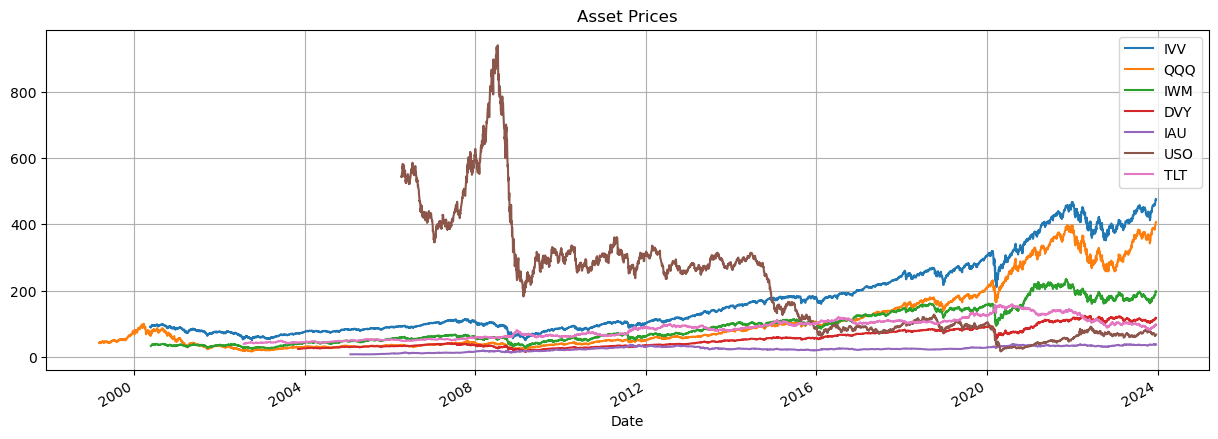

In [131]:
prices = pd.DataFrame({symbol.ticker: get_data(symbol) for symbol in tickers})
prices.plot(grid=True, title='Asset Prices');

## Correlation Plot

<Axes: >

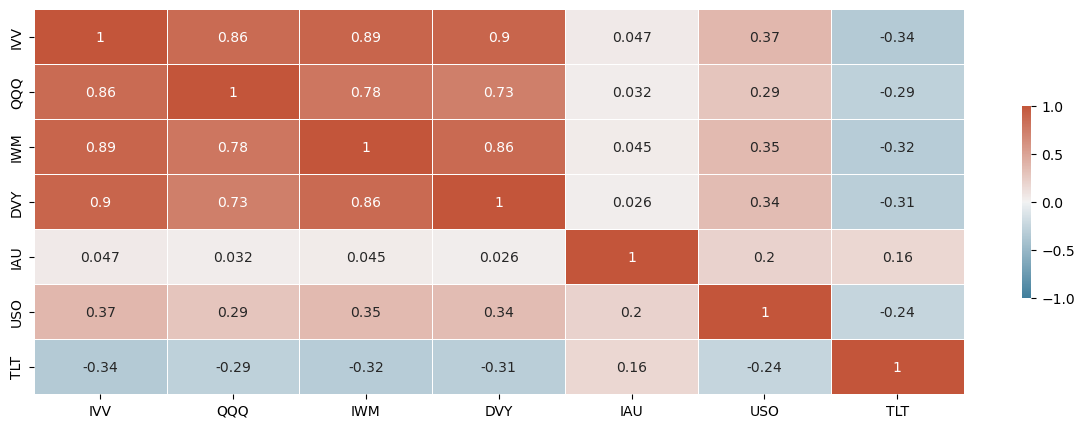

In [132]:
import seaborn as sns
corr = prices.pct_change().corr()
f, ax = plt.subplots()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=1,vmin=-1, center=0,
            linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [133]:
vix = get_data(yf.Ticker('VIX')).resample('D').last().ffill()
vix.index = pd.to_datetime(vix.index).date
vix.index = pd.to_datetime(vix.index)

In [134]:
max([prices[col].first_valid_index() for col in prices.columns])

Timestamp('2006-04-10 00:00:00-0400', tz='America/New_York')

In [135]:
prices = prices[max([prices[col].first_valid_index() for col in prices.columns]):].dropna(axis=1)
prices.index = pd.to_datetime(prices.index).date
prices.index = pd.to_datetime(prices.index)
prices = prices.resample('B').last().ffill().fillna(method='ffill')
full_df = prices.copy()

In [136]:
prices/=prices.iloc[0]

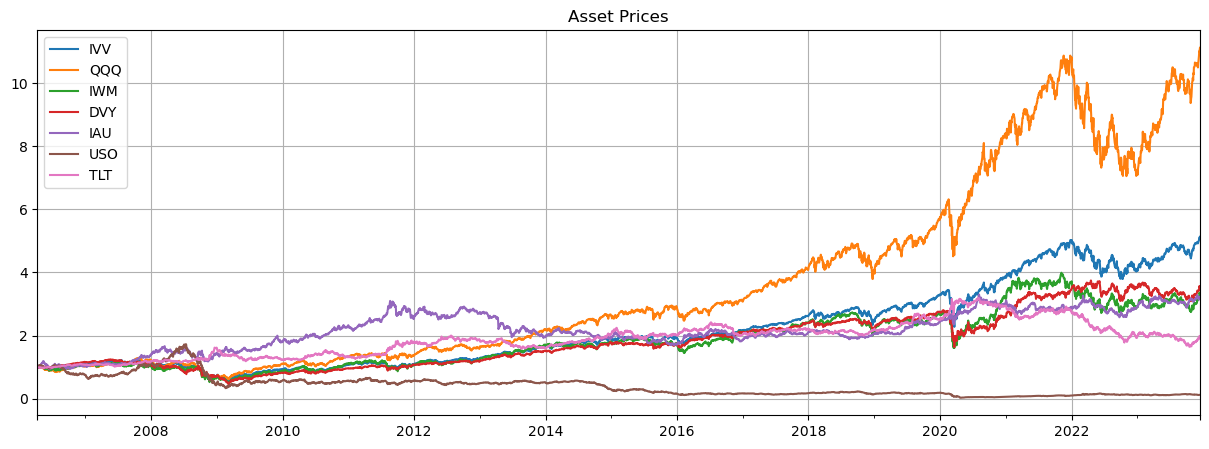

In [137]:
prices.plot(grid=True, title='Asset Prices');

## HERC

The HERC portfolio optimization algoritm is an extension of Marcos Lopez de Prado's Hierarchical Risk Parity algorithm. 
The algorithm consists of 4 main steps:
- Hierarchical tree clustering
- Selecting optimal number of clusters
- Allocation of capital across clusters
- Allocation of capital within clusters

The algorithm is described in the paper: Raffinot, Thomas, The Hierarchical Equal Risk Contribution Portfolio (August 23, 2018). 
Available at:
- https://ssrn.com/abstract=3237540 
- http://dx.doi.org/10.2139/ssrn.3237540

For more information:
- https://medium.com/@TomCapitalAG/portfolio-construction-by-risk-parity-in-the-context-of-machine-learning-62a48d7211d7
- https://research-api.cbs.dk/ws/portalfiles/portal/62178444/879726_Master_Thesis_Nima_Daniel_15736.pdf
- https://github.com/dcajasn/Riskfolio-Lib/blob/d2e7714a7e37839037e46c93fc1149931136d9e6/riskfolio/HCPortfolio.py#L199

In [138]:
from scipy.stats import t
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.optimize import Bounds

class RiskMeasures:
    
    def __init__(self, confidence_level):
        self._confidence_level = confidence_level
    
    def value_at_risk(self, returns):
        return returns.quantile(self._confidence_level)

    def gaussian_var(self, returns):
        z = norm.ppf(self._confidence_level)
        s = returns.skew()
        k = returns.kurtosis()
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
        return (returns.mean() + z*returns.std(ddof=0))
        
    def expected_shortfall(self, returns):
        returns = returns[returns!=0]
        var = self.value_at_risk(returns)
        return abs(returns[returns.lt(var)].mean())

In [139]:
def rolling_cvar(rets):
    rm = RiskMeasures(confidence_level=0.05)
    risk_strategy = rm.expected_shortfall(returns=rets)
    return risk_strategy

In [140]:
import scipy.cluster.hierarchy as hierarchy
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from scipy.spatial.distance import pdist, squareform

class HierarchicalEqualRiskContribution:
    
    def __init__(self):
    
        self.weights = None
        self.asset_order = None
        self.clusters = None
        self.corr = None
        self.corr_sorted = None
        self.min_risk = None
        self.max_risk = None
                
    # get inverse-variance/volatility weights
    def inv_var(self, returns, cov, risk_lookback, w_method='var', confidence_level=0.05):
        cov = pd.DataFrame(cov)        
        assets = cov.columns.tolist()
        n = len(assets)
        sr = RiskMeasures(confidence_level=confidence_level)
        
        if w_method == 'var':
            inv_diag = 1 / np.diag(cov.values)
        elif w_method == 'vol':
            inv_diag = 1 / np.sqrt(np.diag(cov.values))
        elif w_method in ['cvar']:
            inv_diag = np.zeros((n, 1))
            for i in assets:
                k = assets.index(i)
                if w_method == 'cvar':
                    risk_strategy = sr.expected_shortfall(returns=returns[i][-risk_lookback:])

                    if not self.min_risk is None:
                        risk = max(self.min_risk, risk_strategy)
                    else:
                        risk = risk_strategy
                        
                    if not self.max_risk is None:
                        risk = min(self.max_risk, risk)
                    
                    #print(i,risk)

                inv_diag[k, 0] = 1 / risk
        
        weight = inv_diag * (1 / np.sum(inv_diag))
        weight = weight.reshape(-1,1)
        return weight
    
    def hierarchical_clustering(self, corr, linkage, max_k, leaf_order=True):
        
        # hierarchcial clustering
        dist = np.sqrt((1 - corr).round(5) / 2)
        dist = pd.DataFrame(dist, columns=corr.columns, index=corr.index)
        p_dist = pdist(dist)
        clustering = hierarchy.linkage(p_dist, method=linkage, optimal_ordering=leaf_order)
        
        # cluster levels over from 1 to N-1 clusters
        cluster_lvls = pd.DataFrame(hierarchy.cut_tree(clustering), index=corr.columns)
        num_k = cluster_lvls.columns # save column with number of clusters
        cluster_lvls = cluster_lvls.iloc[:, ::-1] # reverse order to start with,→ 1 cluster
        cluster_lvls.columns = num_k # set columns to number of cluster
        W_list = []
        
        for k in range(min(len(cluster_lvls.columns), max_k)):
            level = cluster_lvls.iloc[:,k] # get k clusters
            D_list = [] # within-cluster distance list
            
            for i in range(np.max(level.unique())+1):
                cluster = level.loc[level == i] 
                # Based on correlation distance 
                cluster_dist = dist.loc[cluster.index, cluster.index] # get distance
                cluster_pdist = pdist(cluster_dist) # flatten and transform to squared euclidean
                D = np.nan_to_num(cluster_pdist.std())
                D_list.append(D) # append to list
                
            W_k = np.sum(D_list)
            W_list.append(W_k)
        
        W_list = pd.Series(W_list)
        n = corr.shape[0]
        limit_k = int(min(max_k, np.sqrt(n)))
        gaps = W_list.shift(-2) + W_list - 2*W_list.shift(-1)
        gaps = gaps[0:limit_k]
        k = gaps.idxmax() + 2
        
        return clustering, k
    
    def seriation(self, clusters):
        return hierarchy.leaves_list(clusters)
    
    def hierarchical_recursive_bisection(self, cov, linkage, k, w_method, returns, risk_lookback, confidence_level):
        # Transform linkage to tree and reverse order
        root, nodes = hierarchy.to_tree(linkage, rd=True)
        nodes = nodes[::-1]
        items = pd.Series(data=hierarchy.leaves_list(linkage)) # Get list of assets
        weight = pd.Series(1, index=cov.index) # Set initial weights to 1
        
        # Loop through k clusters
        for i in nodes[:k-1]:
            if i.is_leaf() == False: # skip leaf-nodes
                left = i.get_left().pre_order() # lambda i: i.id get left cluster
                right = i.get_right().pre_order() # lambda i: i.id get right cluster
                
                # Left cluster
                left_cov = cov.iloc[left, left]
                left_weight = self.inv_var(returns, left_cov, risk_lookback, w_method, confidence_level)
                left_var = np.dot(np.dot(left_weight.T, left_cov), left_weight)[0,0]
                
                # Right cluster
                right_cov = cov.iloc[right, right]
                right_weight = self.inv_var(returns, right_cov, risk_lookback,  w_method, confidence_level)
                right_var = np.dot(np.dot(right_weight.T, right_cov), right_weight)[0,0]
                
                # Allocate weight to clusters
                alpha = 1 - left_var / (left_var + right_var)
                weight[left] *= alpha # weight 1
                weight[right] *= 1 - alpha # weight 2
                
        # Get constituents of k clusters
        clustered_assets = pd.Series(hierarchy.cut_tree(linkage, n_clusters=k).flatten(), index=cov.index)
        w = pd.DataFrame(np.ones(len(cov.index)), index=cov.index)
        
        # Multiply within-cluster weight with inter-cluster weight
        for i in range(k):
            cluster = clustered_assets.loc[clustered_assets == i]
            cluster_cov = cov.loc[cluster.index, cluster.index]
            cluster_weights = pd.Series(self.inv_var(returns, cluster_cov, risk_lookback, w_method, confidence_level).flatten(), index=cluster_cov.index)
            weight.loc[cluster_weights.index] *= cluster_weights
        
        return weight

    def cov2corr(self, cov):
        std = np.sqrt(np.diag(cov))
        corr = cov / np.outer(std, std)
        corr[corr < -1], corr[corr > 1] = -1, 1 #numerical error
        return corr
    
    # Allocate weights
    def allocate(self, cov, returns, risk_lookback, linkage='ward', max_k=20, w_method='var', min_risk = None, max_risk = None, confidence_level = 0.05):
        self.min_risk = min_risk
        self.max_risk = max_risk        
        # Correlation matrix from covariance matrix
        self.corr = self.cov2corr(cov)
        # Step-1: Tree clustering
        self.clusters, self.k, = self.hierarchical_clustering(self.corr, linkage, max_k)
        # Step-2: Seriation (Quasi-Diagnalization)
        self.sort_order = self.seriation(self.clusters)
        asset_order = list(cov.columns)
        asset_order[:] = [asset_order[i] for i in self.sort_order]
        self.asset_order = asset_order
        self.corr_sorted = self.corr.reindex(index=self.asset_order, columns=self.asset_order)
        # Step-3: Recursive Bisection
        self.weights = self.hierarchical_recursive_bisection(cov, self.clusters, self.k, w_method, returns, risk_lookback, confidence_level)
        return self.weights

In [141]:
from dateutil.relativedelta import relativedelta
def get_market_weights(d=None, cov_min = -0.5, cov_max = 0.5, risk_lookback = 52, w_method = 'cvar', max_k = 10, min_risk = 2.5, max_risk = 9, return_lookback_years = None, return_decay = None):
    
    if return_decay is None:
        returns = np.log(full_df.resample('W').last()).diff().fillna(method='ffill').fillna(0)*100
    else:
        returns = np.log(full_df.ewm(alpha=1-return_decay).mean().resample('W').last()).diff().fillna(method='ffill').fillna(0)*100
    start_date = d - relativedelta(years = return_lookback_years) if return_lookback_years is not None else returns.first_valid_index()

    if d is not None:
        returns = returns[start_date:d-relativedelta(days=1)]
        
    corr = returns.corr()
    cov = returns.cov()
    covc = np.minimum(cov_max, np.maximum(cov_min, cov))
    
    hrc = HierarchicalEqualRiskContribution()
    herc = hrc.allocate(cov=covc, returns=returns, max_k=max_k, w_method=w_method, risk_lookback=risk_lookback, min_risk = min_risk, max_risk = max_risk)
    
    # Risk parity
    ivp = 1 / np.diag(covc)
    ivp /= ivp.sum()
    
    
    # Kelly Criterion (E. Chan, Quantitative Trading, 2008):
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    precision_matrix = pd.DataFrame(np.linalg.inv(cov_matrix), index=returns.columns, columns=returns.columns)
    kelly_wt = precision_matrix.dot(mean_returns).values
    
    #Equal Weight
    ew = np.ones(len(covc.columns)) / len(covc.columns)
    
    return herc, ivp, kelly_wt, ew

In [142]:
dates = pd.date_range(datetime.datetime(2008,1,1), datetime.datetime.now(), freq='M')[1:]

In [143]:
herc_settings = dict(cov_min = -1, cov_max = 1, risk_lookback = 52, w_method = 'cvar', max_k = 3, min_risk = 2.5, max_risk = 10, return_lookback_years = 10)

In [144]:
# we want to calculate the weights for the HERC and IVP portfolios once a month
wfwds = [get_market_weights(d=d.date(), 
                            cov_min = herc_settings['cov_min'], 
                            cov_max = herc_settings['cov_max'],  
                            risk_lookback = herc_settings['risk_lookback'], 
                            w_method = herc_settings['w_method'], 
                            max_k = herc_settings['max_k'], 
                            min_risk = herc_settings['min_risk'], 
                            max_risk = herc_settings['max_risk'], 
                            return_lookback_years = herc_settings['return_lookback_years']) 
            for d in dates]

dfw_herc = pd.DataFrame([w[0] for w in wfwds], index=dates) 
dfw_ivp = pd.DataFrame([w[1] for w in wfwds], index=dates, columns = dfw_herc.columns)
dfw_kc = pd.DataFrame([w[2] for w in wfwds], index=dates, columns = dfw_herc.columns)
dfw_ew = pd.DataFrame([w[3] for w in wfwds], index=dates, columns = dfw_herc.columns)

c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

In [145]:
dfw_herc.tail()

,IVV,QQQ,IWM,DVY,IAU,USO,TLT
2023-07-31,0.125122,0.104772,0.087605,0.123423,0.295276,0.059078,0.204724
2023-08-31,0.124837,0.105673,0.087405,0.123142,0.302555,0.058943,0.197445
2023-09-30,0.134611,0.112616,0.087730,0.114348,0.311301,0.050696,0.188699
2023-10-31,0.131809,0.110272,0.085903,0.122376,0.300273,0.049640,0.199727
2023-11-30,0.128525,0.129104,0.080724,0.114999,0.287981,0.046648,0.212019


## Backtest

The backtest is run on the full dataset, but the portfolio is rebalanced only on the rebalancing dates to reduce transaction costs. 
We calculate the number of shares to hold for each asset based on the target weights and the current prices.
We then calculate the total investment after rebalancing and the portfolio value for the days between rebalancing dates.
The idea is that this should be an investible portfolio with minimum trading costs and little work to maintain.

In [146]:
def run_backtest(weights, aum):
    """
    
    """
    # Create a rebalancing schedule (monthly)
    rebalancing_dates = weights.index

    # Initialize portfolio value and track performance
    portfolio_value = [aum]  # Start with an initial investment equal to aum
    portfolio_weights = []
    dates = []

    for i in range(1, len(full_df)):
        date = full_df.index[i]
        
        if date < rebalancing_dates[0]:
            continue
        
        current_prices = full_df.loc[date]
        
        # Check if it's the end of the month (rebalancing date)
        if date in rebalancing_dates:
            
            # Get the current weights and prices at the rebalancing date
            current_weights = weights.loc[date].to_dict()
            total_investment = portfolio_value[-1]

            # Calculate the number of shares to hold for each asset based on target weights
            shares_to_hold = {asset: total_investment * weight / price
                            for asset, weight, price in zip(current_weights.keys(),
                                                            current_weights.values(),
                                                            current_prices.values)}

            # Update the portfolio value with the total investment after rebalancing
            total_investment = sum(shares_to_hold[asset] * price
                                   for asset, price 
                                   in zip(current_prices.index, current_prices.values))
            
            #total_investment = total_investment * (1 - 0.0005) # 0.05% transaction cost
            total_investment = total_investment - len(weights.columns) # 1$ transaction cost
            
            portfolio_value.append(total_investment)
            portfolio_weights.append(current_weights)
            
        else:
            # Interpolate the portfolio value for the days between rebalancing dates
            total_investment = sum(shares_to_hold[asset] * price
                                   for asset, price 
                                   in zip(current_prices.index, current_prices.values))
            
            portfolio_value.append(total_investment)
        
        dates.append(date)

    # Convert the results to a DataFrame
    results_df = pd.DataFrame({'Cumulative': portfolio_value[1:]}, index=dates)
    results_df['Returns'] = results_df['Cumulative'].pct_change()
    
    return results_df


In [147]:
results_df = run_backtest(dfw_herc, 10000)

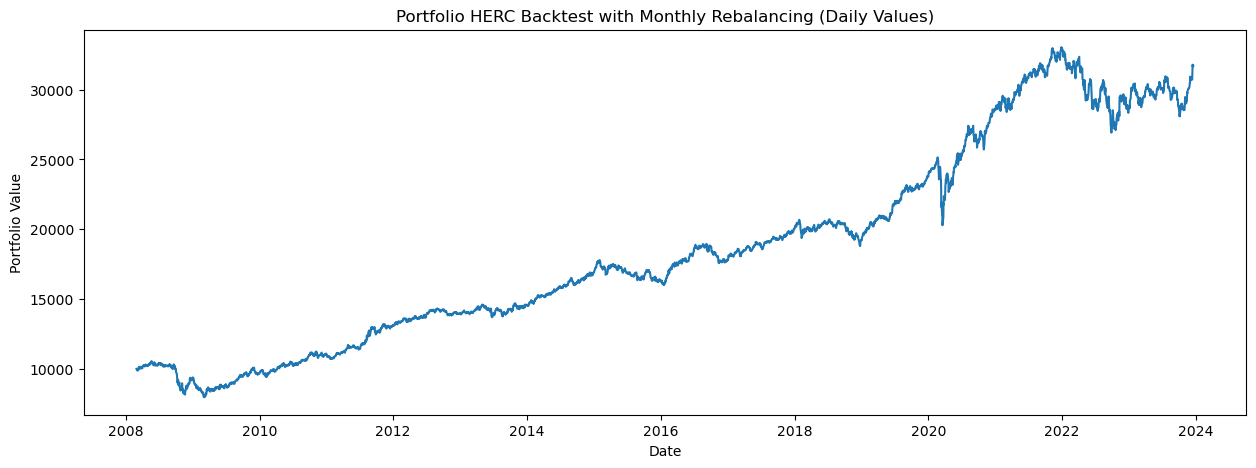

In [148]:
# Plot the portfolio value over time
plt.figure()
plt.plot(results_df.index, results_df['Cumulative'])
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio HERC Backtest with Monthly Rebalancing (Daily Values)')
plt.show()

<Axes: title={'center': 'Asset Weights'}>

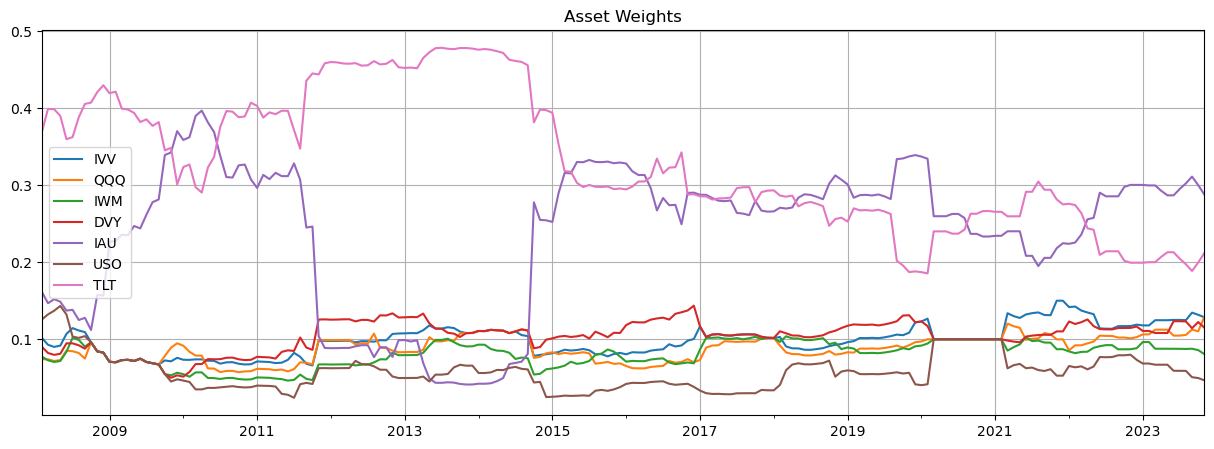

In [149]:
dfw_herc.plot(grid=True, title='Asset Weights')

Equities
Commodities
FixedIncome


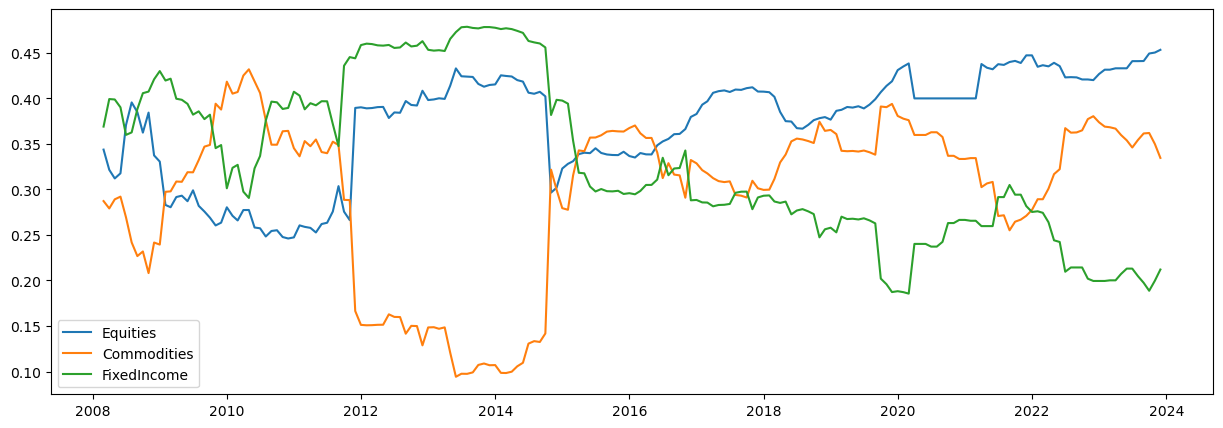

In [150]:
fig, ax = plt.subplots()
for asset_class in universe.keys():
    print(asset_class)
    plt.plot(dfw_herc[universe[asset_class].keys()].sum(axis=1), label=asset_class)
plt.legend();

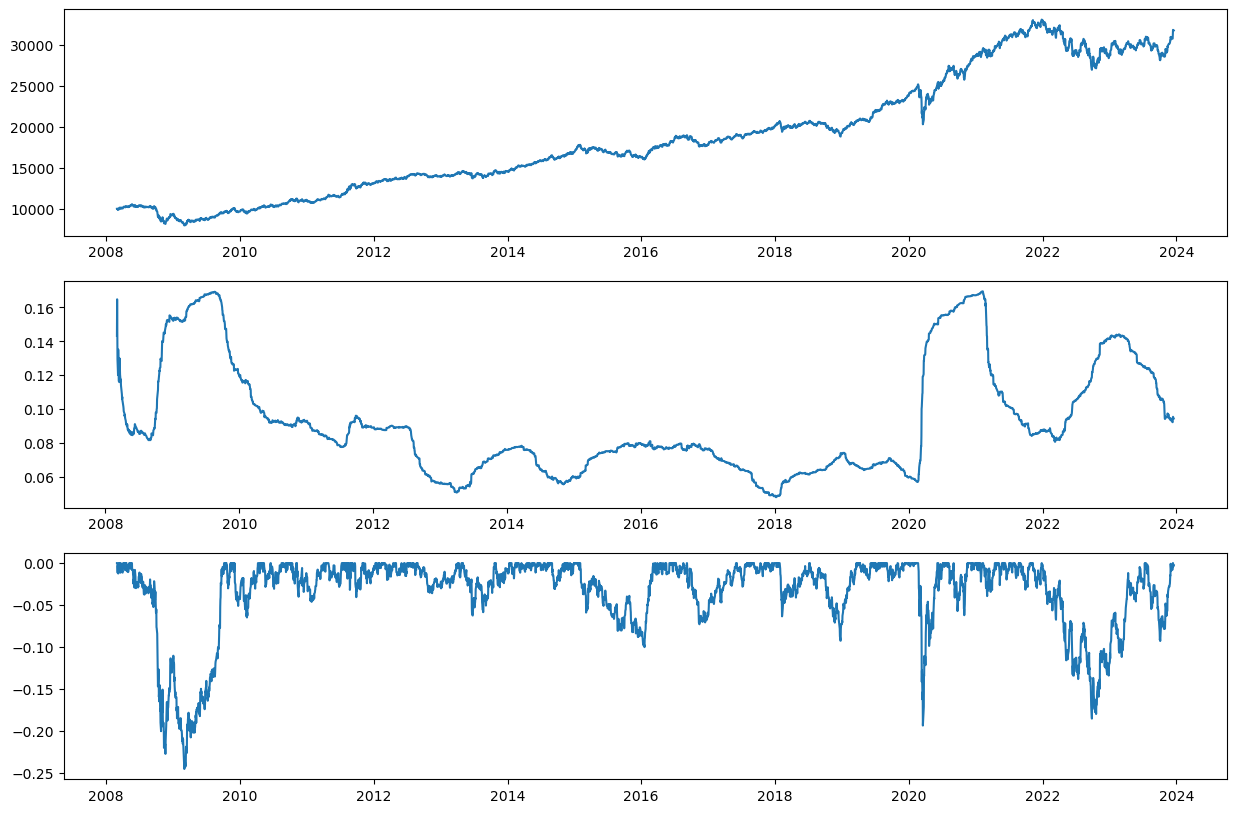

In [151]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,10))
ax[0].plot(results_df['Cumulative'], label='Portfolio')
ax[1].plot(results_df['Returns'].rolling(window=252, min_periods=1).std()*np.sqrt(252), label='Rolling STD')
ax[2].plot(results_df['Cumulative']/results_df['Cumulative'].rolling(window=252, min_periods=1).max()-1, label='Rolling DD');

In [152]:
results_ivp = run_backtest(dfw_ivp, 10000)
results_ew = run_backtest(dfw_ew, 10000)

In [153]:
print(results_df['Returns']['2008-06':].mean()/results_df['Returns']['2008-06':].std()*np.sqrt(252))
print(results_ivp['Returns']['2008-06':].mean()/results_ivp['Returns']['2008-06':].std()*np.sqrt(252))
print(results_ew['Returns']['2008-06':].mean()/results_ew['Returns']['2008-06':].std()*np.sqrt(252))

0.7637279577556676
0.5317351125817634
0.5317351125817634


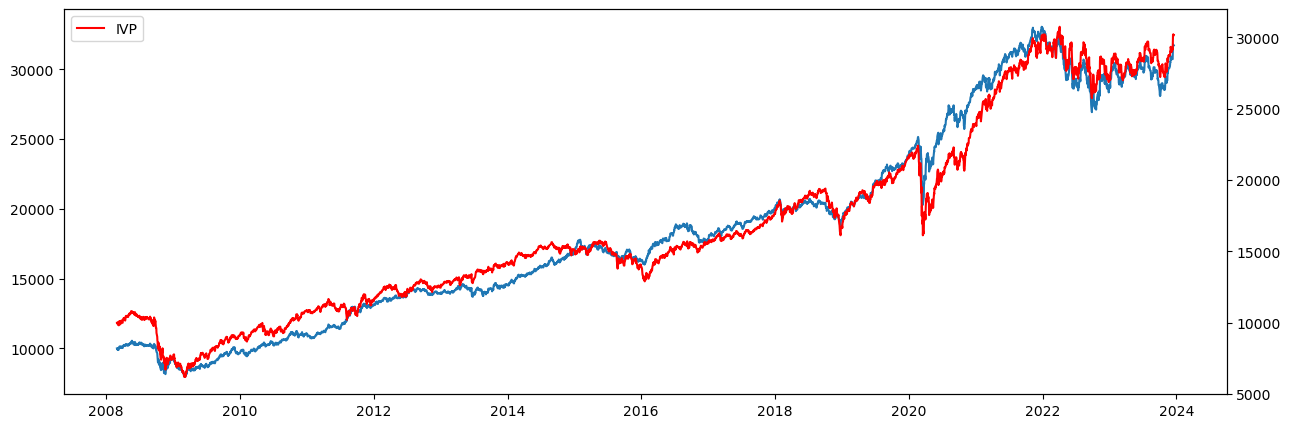

In [154]:
fig, ax = plt.subplots()
ax.plot(results_df['Cumulative'], label='HERC')
ax1 = ax.twinx()
ax1.plot(results_ivp['Cumulative'], label='IVP', color='red')
plt.legend();

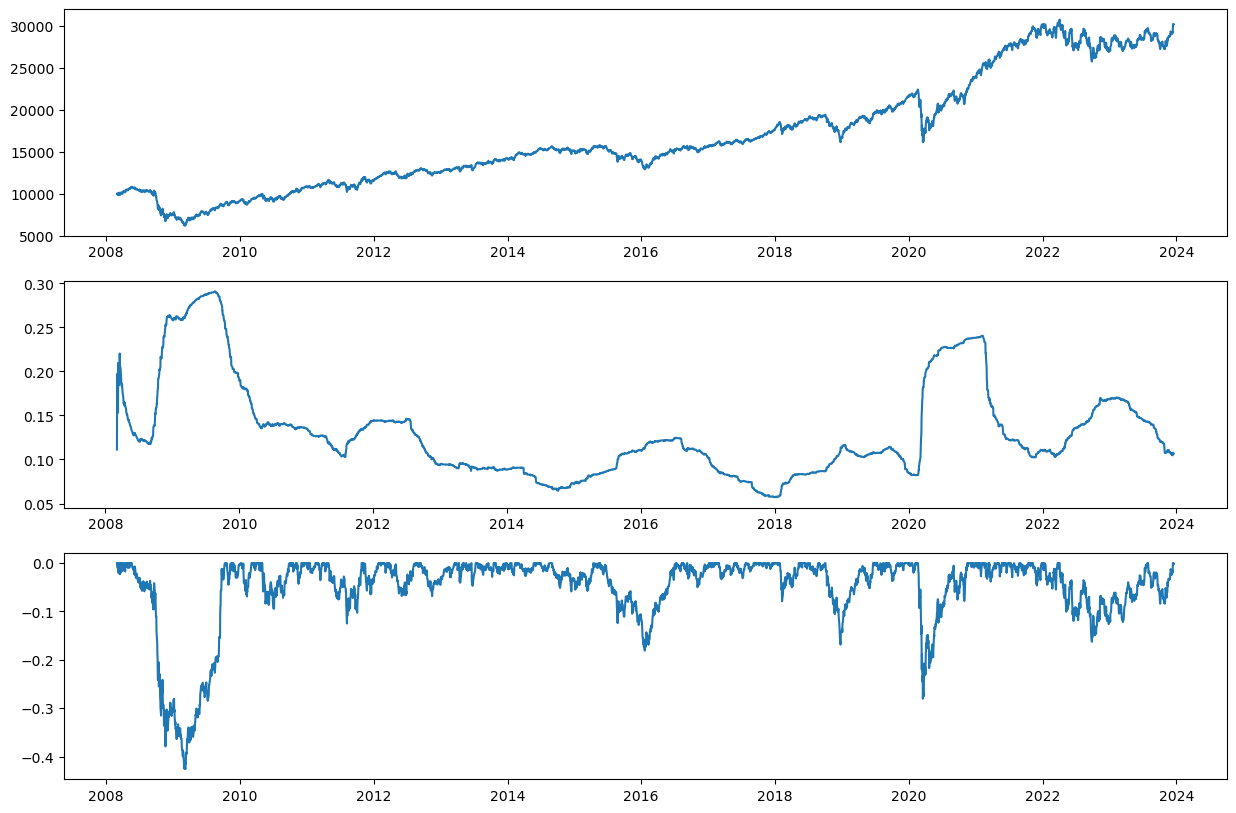

In [155]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,10))
ax[0].plot(results_ivp['Cumulative'], label='Portfolio')
ax[1].plot(results_ivp['Returns'].rolling(window=252, min_periods=1).std()*np.sqrt(252), label='Rolling STD')
ax[2].plot(results_ivp['Cumulative']/results_ivp['Cumulative'].rolling(window=252, min_periods=1).max()-1, label='Rolling STD');

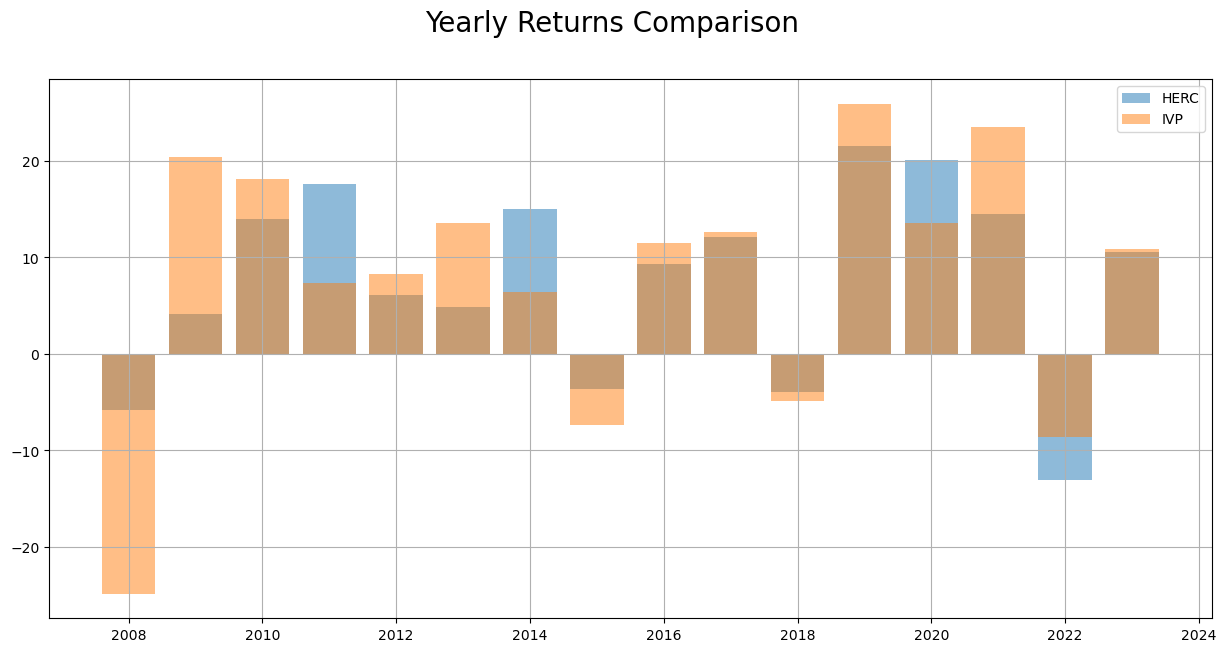

In [156]:
yearly_returns = ((results_df['Returns']).groupby([results_df['Returns'].index.year]).sum()*100)
yearly_returns_ivp = ((results_ivp['Returns']).groupby([results_ivp['Returns'].index.year]).sum()*100)
fig, ax = plt.subplots(figsize=(15,7))
ax.bar(yearly_returns.index, yearly_returns, label='HERC', alpha=0.5)
ax.bar(yearly_returns_ivp.index, yearly_returns_ivp, label='IVP', alpha=0.5)
fig.suptitle('Yearly Returns Comparison', fontsize=20)
plt.grid(True)
plt.legend();

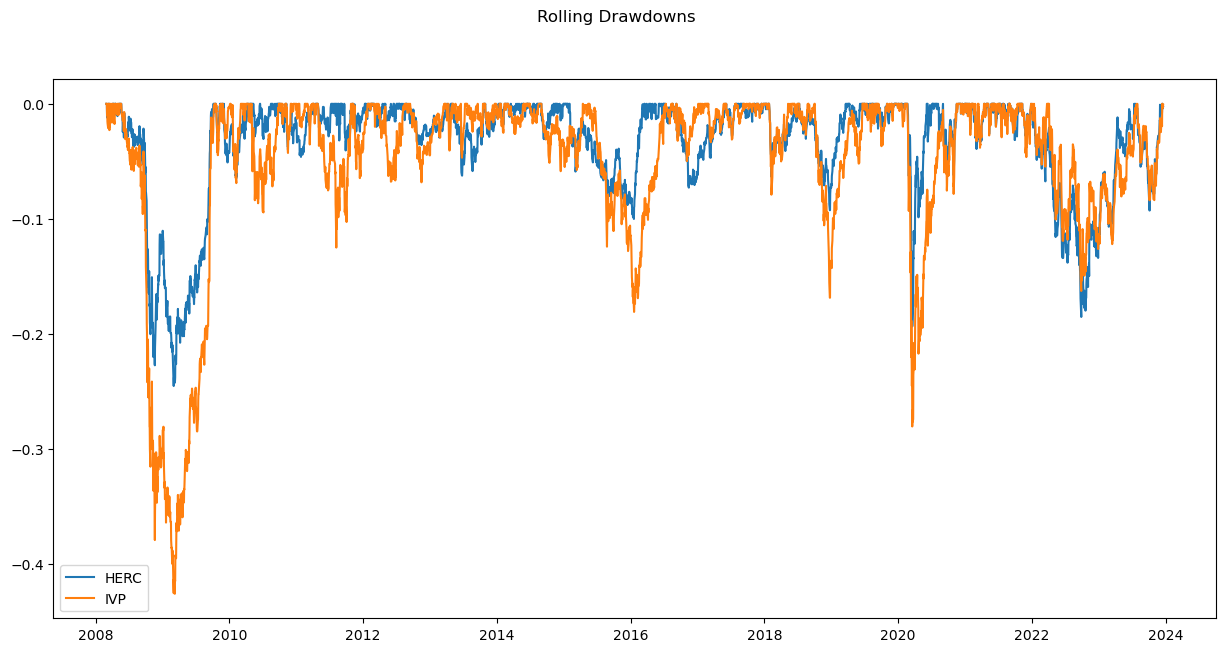

In [157]:
fig, ax = plt.subplots(figsize=(15,7))
fig.suptitle('Rolling Drawdowns')
ax.plot(results_df['Cumulative']/results_df['Cumulative'].rolling(window=252, min_periods=1).max()-1, label='HERC')
ax.plot(results_ivp['Cumulative']/results_ivp['Cumulative'].rolling(window=252, min_periods=1).max()-1, label='IVP')
plt.legend();

### Momentum Overlay: Scale the weights by the momentum of the time series
###### Based on Rob Carvers book "Advanced Futures Trading Strategies" https://github.com/robcarver17

In [158]:
def ewmac_forecast_scalar(Lfast, Lslow):
    fsdict=dict(l2_8=10.6, l4_16=7.5, l8_32=5.3, l16_64=3.75, l32_128=2.65, l64_256=1.87)
    
    lkey="l%d_%d" % (Lfast, Lslow)
    
    if lkey in fsdict:
        return fsdict[lkey]
    else:
        print ("Warning: No scalar defined for Lfast=%d, Lslow=%d, using default of 1.0" % (Lfast, Lslow))
        return 1.0
   
def ewmac(price, Lfast=16):
    
    vol_lookback = 25
    Lslow=4*Lfast
    
    fast_ewma=price.ewm(span=Lfast).mean()
    slow_ewma=price.ewm(span=Lslow).mean()
    raw_ewmac=fast_ewma - slow_ewma
    
    stdev_returns=price.diff().ewm(span=vol_lookback).std()
    vol_adj_ewmac=raw_ewmac/stdev_returns
    
    f_scalar=ewmac_forecast_scalar(Lfast, Lslow)

    forecast=vol_adj_ewmac*f_scalar
    
    return (np.maximum(np.minimum(forecast, 20), -20)/2 + 10)/20 # Scale to [0,1]

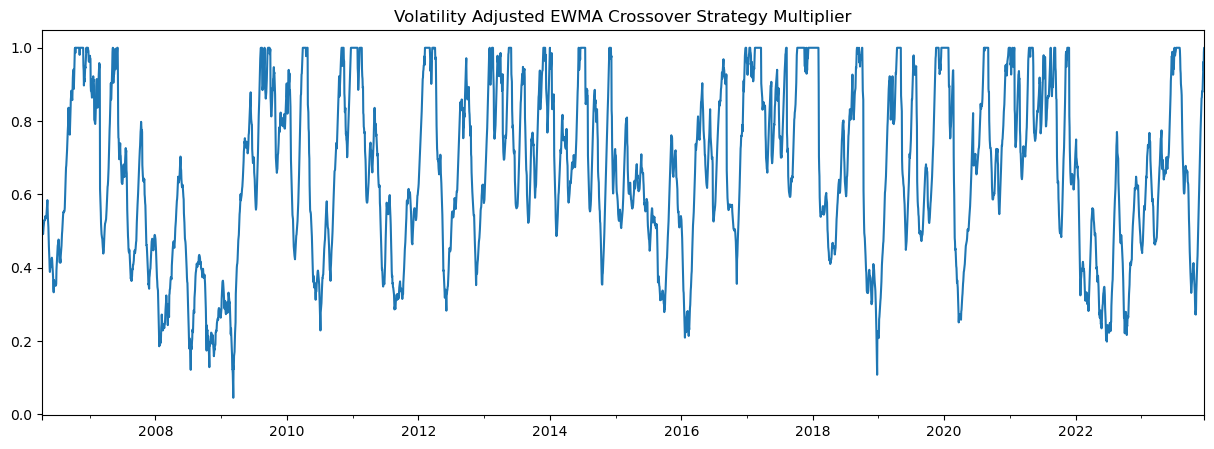

In [159]:
vol_adj_ewmac = ewmac(prices['IVV'])
vol_adj_ewmac.plot(title='Volatility Adjusted EWMA Crossover Strategy Multiplier');

In [160]:
ewmacs = pd.DataFrame([ewmac(prices[symbol.ticker], Lfast=16) for symbol in tickers], index=symbols).T
ewmacs = ewmacs.resample('D').last().ffill().fillna(method='ffill').shift(1)
ewmacs_full = ewmacs.copy()

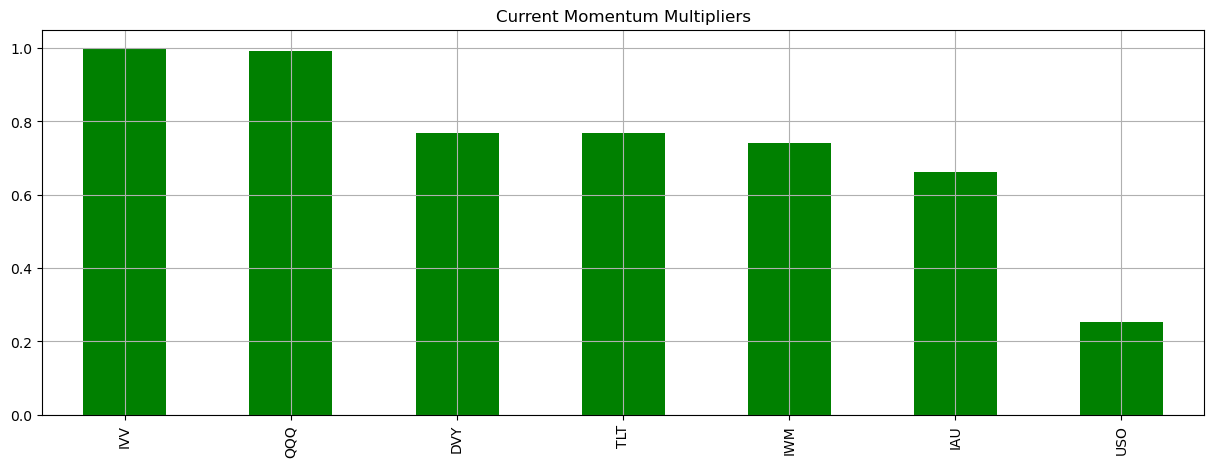

In [161]:
ewmacs.iloc[-1].sort_values(ascending=False).plot.bar(title='Current Momentum Multipliers', color='green', grid=True);

In [162]:
#scale HERC weights by EWMA momentum
dfw_mom = dfw_herc * (ewmacs.loc[dfw_herc.index])
dfw_mom /= dfw_mom.sum(axis=1).values.reshape(-1,1)

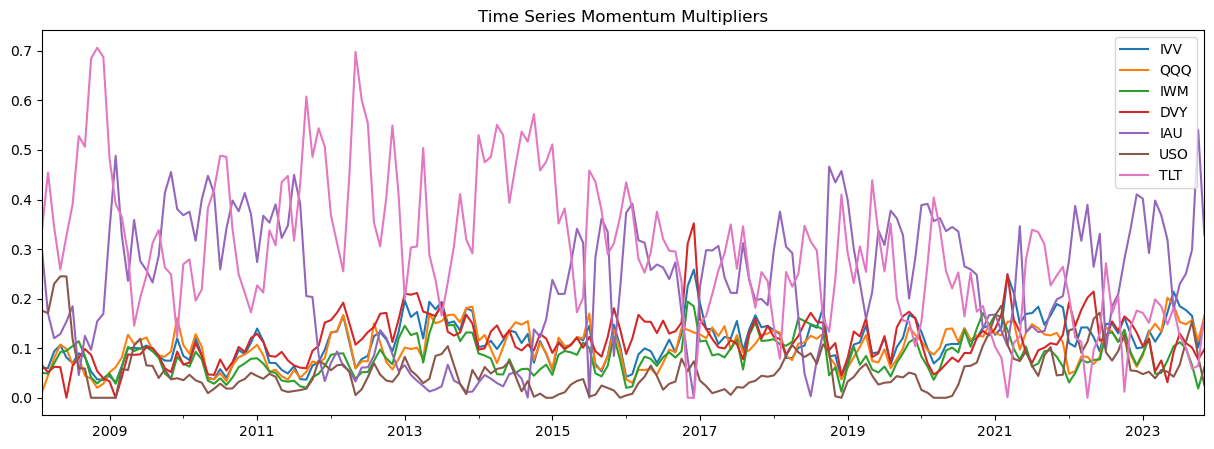

In [163]:
dfw_mom.plot(figsize=(15,5), title='Time Series Momentum Multipliers');

In [164]:
results_mom = run_backtest(dfw_mom, 10000)

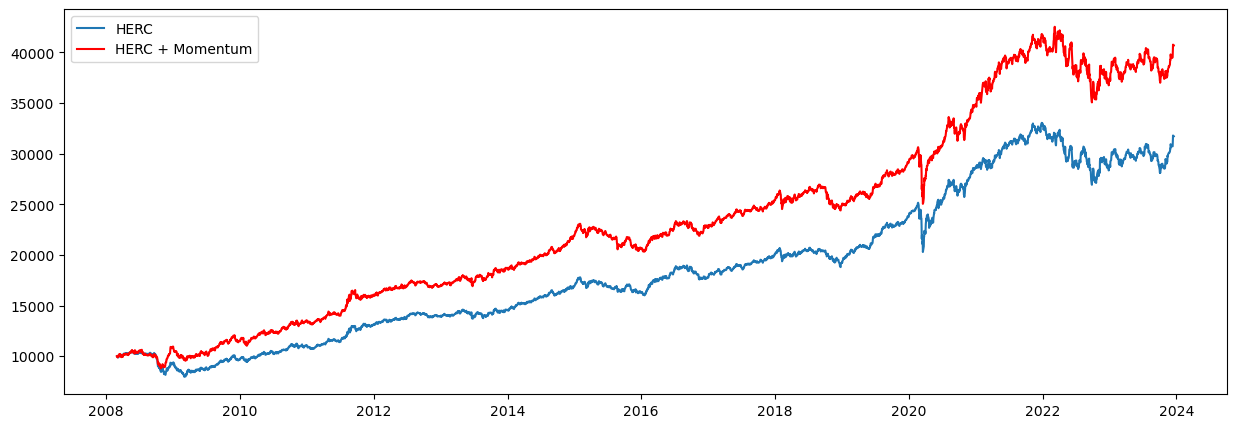

In [165]:
fig, ax = plt.subplots()
plt.plot(results_df.index, results_df['Cumulative'], label='HERC')
plt.plot(results_mom.index, results_mom['Cumulative'], label='HERC + Momentum', color='red')
plt.legend();

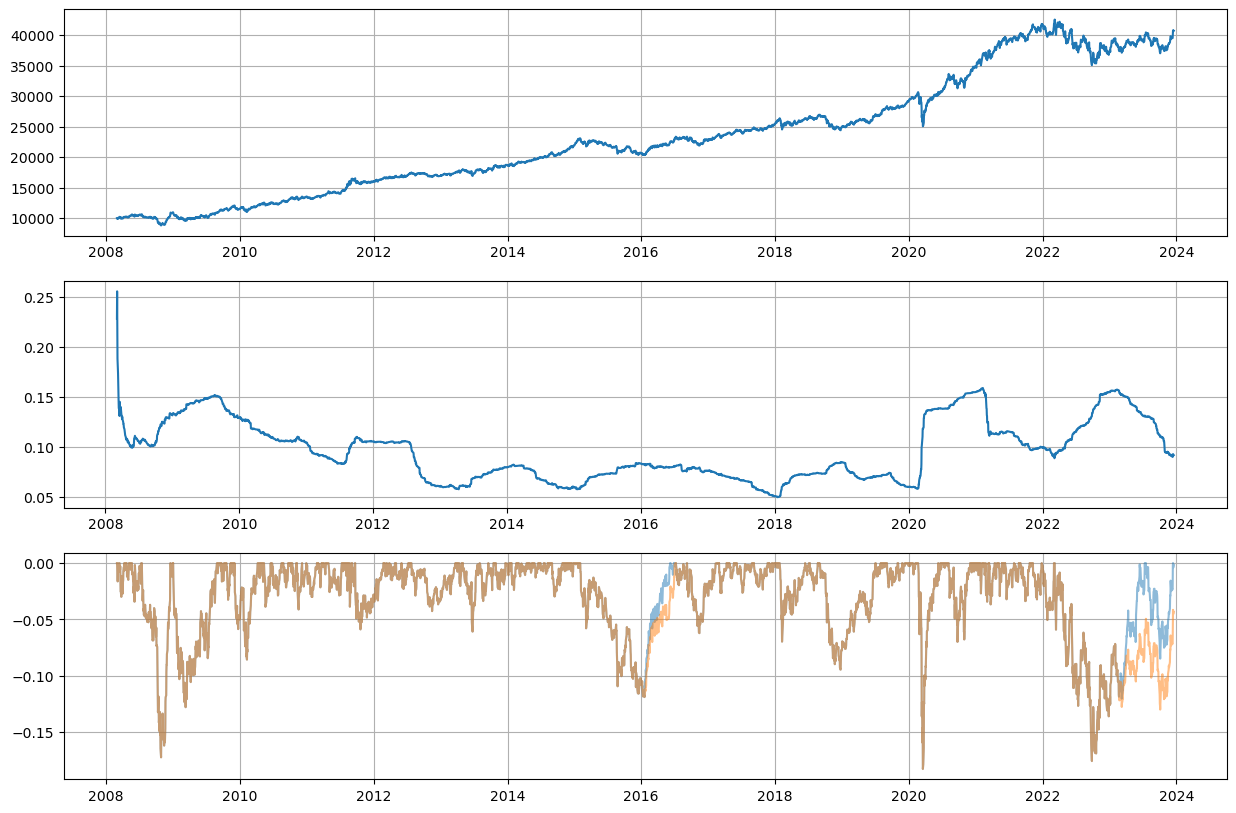

In [166]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,10))
ax[0].plot(results_mom['Cumulative'], label='Portfolio')
ax[1].plot(results_mom['Returns'].rolling(window=252, min_periods=1).std()*np.sqrt(252), label='Rolling STD')
ax[2].plot(results_mom['Cumulative']/results_mom['Cumulative'].rolling(window=252, min_periods=1).max()-1, label='Rolling 1 Year DD', alpha=0.5)
ax[2].plot(results_mom['Cumulative']/results_mom['Cumulative'].expanding().max()-1, label='DD', alpha=0.5)

[ax[i].grid(True) for i in range(3)];

In [167]:
results_mom['Returns']['2008-06':].mean()/results_mom['Returns']['2008-06':].std()*np.sqrt(252)

0.9016533502283728

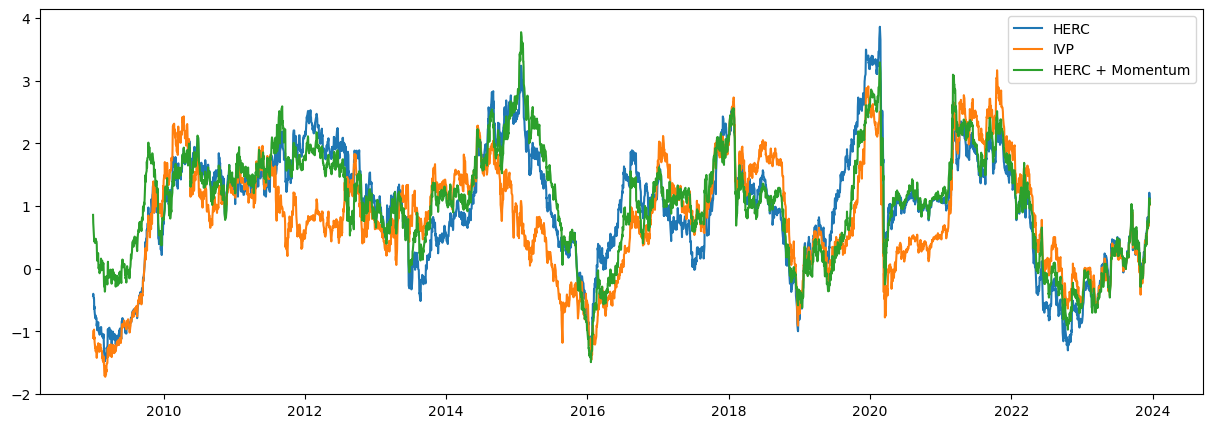

In [168]:
rolling_sharpe_herc = results_df['Returns'].rolling(window=252, min_periods=1).mean()/results_df['Returns'].rolling(window=252, min_periods=1).std()*np.sqrt(252)
rolling_sharpe_ivp = results_ivp['Returns'].rolling(window=252, min_periods=1).mean()/results_ivp['Returns'].rolling(window=252, min_periods=1).std()*np.sqrt(252)
rolling_sharpe_mom = results_mom['Returns'].rolling(window=252, min_periods=1).mean()/results_mom['Returns'].rolling(window=252, min_periods=1).std()*np.sqrt(252)
rolling_sharpe = pd.concat([rolling_sharpe_herc, rolling_sharpe_ivp, rolling_sharpe_mom], axis=1)
rolling_sharpe.columns = ['HERC', 'IVP', 'HERC + Momentum']
rolling_sharpe = rolling_sharpe['2009':]


fig, ax = plt.subplots(figsize=(15,5))
plt.plot(rolling_sharpe['HERC'], label='HERC')
plt.plot(rolling_sharpe['IVP'], label='IVP')
plt.plot(rolling_sharpe['HERC + Momentum'], label='HERC + Momentum')
plt.legend();

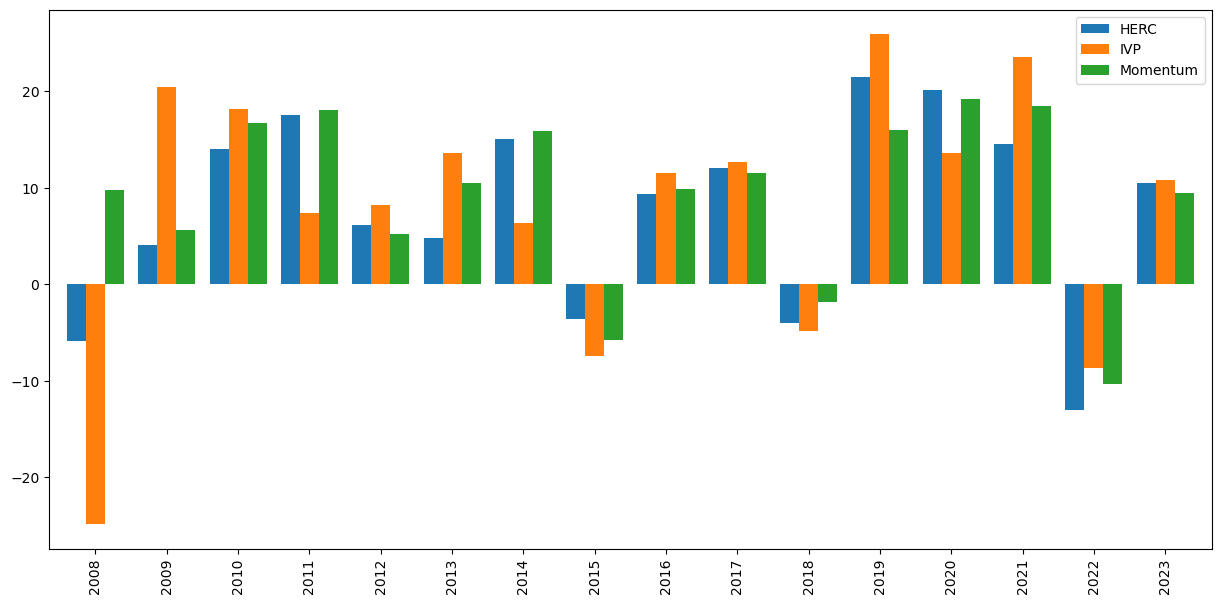

In [169]:
yearly_returns_mom = ((results_mom['Returns']).groupby([results_mom['Returns'].index.year]).sum()*100)
comb_returns = pd.concat([yearly_returns, yearly_returns_ivp, yearly_returns_mom], axis=1)
comb_returns.columns = ['HERC', 'IVP', 'Momentum']
comb_returns.plot(kind='bar', width=0.8, figsize=(15,7));

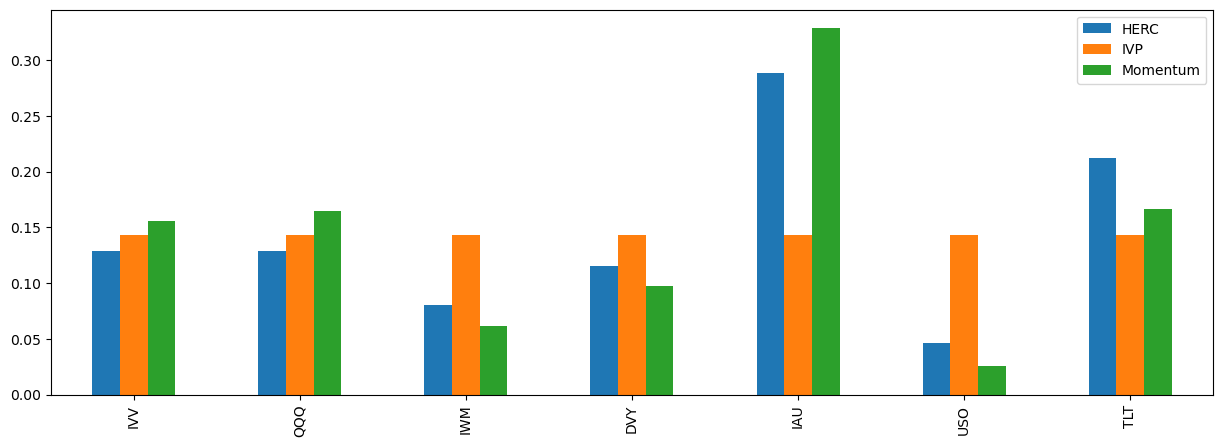

In [170]:
weight_comp = pd.concat([dfw_herc.iloc[-1],dfw_ivp.iloc[-1], dfw_mom.iloc[-1]], axis=1)
weight_comp.columns = ['HERC', 'IVP', 'Momentum']
weight_comp.plot(kind='bar', figsize=(15,5));


In [171]:
def cum_res_date(_df_in, date):
    _df_in = _df_in.loc[date:]
    _df_in/=_df_in.iloc[0]
    return _df_in

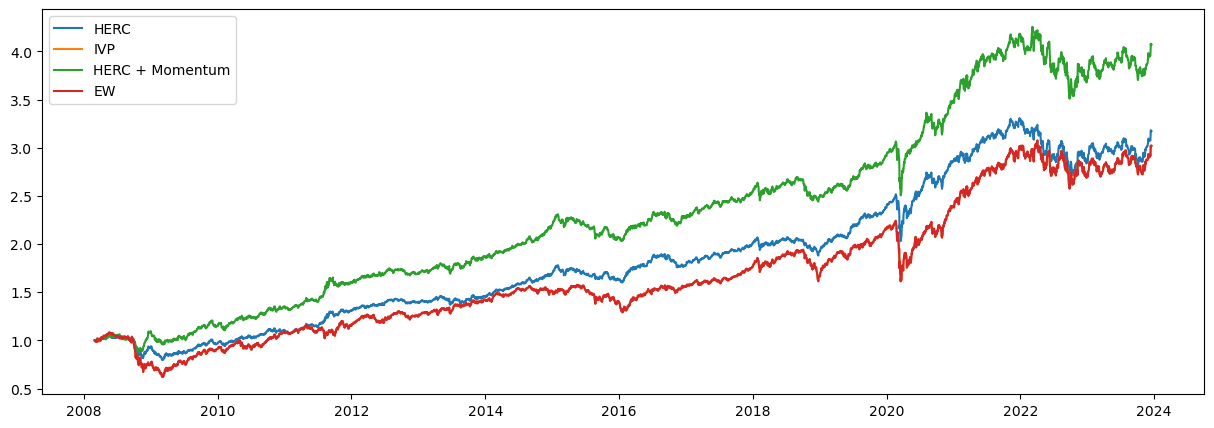

In [172]:
start_date = '2008'
plt.plot(cum_res_date(results_df['Cumulative'].copy(), start_date))
plt.plot(cum_res_date(results_ivp['Cumulative'].copy(), start_date))
plt.plot(cum_res_date(results_mom['Cumulative'].copy(), start_date))
plt.plot(cum_res_date(results_ew['Cumulative'].copy(), start_date))
plt.legend(['HERC', 'IVP', 'HERC + Momentum', 'EW'])

## Risk Managed Strategies
- One idea to reduce drawdowns is to exit the portfolio when we see stress in the market. 
- Below we use a simple indicator of stress: realized stress as measured by the expected shortfall of the SPX ETF. 
- If the stress indicator is above it's average, we would exit the portfolio. We would re-enter if this normalized, at the next monthly rebalancing date.
- With this we try to cut out only the most volatile of phases. Our goal is still to stay invested as much as possible but reduce the very deep Drawdowns of a long-only ETF strategy

**Note that this is not how this strategy would probably be traded live as we would focus reducing exposure only to those assets in stress. We could look more closely at things like marginal contribution to risk etc to determine this.


In [173]:
def fun_rolling_cvar(rets):
    rm = RiskMeasures(confidence_level=0.05)
    risk_strategy = rm.expected_shortfall(returns=rets)
    return risk_strategy

In [174]:
rolling_cvar = full_df['IVV'].pct_change().rolling(window=20).apply(fun_rolling_cvar)
rolling_cvar = rolling_cvar.shift()

In [175]:
df_risk = pd.DataFrame(rolling_cvar.ewm(span=20).mean())
df_risk.columns = ['Risk']
df_risk['limit'] = df_risk['Risk'].rolling(window=250, min_periods=1).mean() + df_risk['Risk'].rolling(window=250, min_periods=1).std()*0.5
df_risk['breached'] = np.where(df_risk['Risk'] > df_risk['limit'], 1, 0)
df_risk['action'] = df_risk['breached'].diff()
df_risk = df_risk[dfw_mom.first_valid_index():] 

In [176]:
df_risk['IVV'] = full_df['IVV']

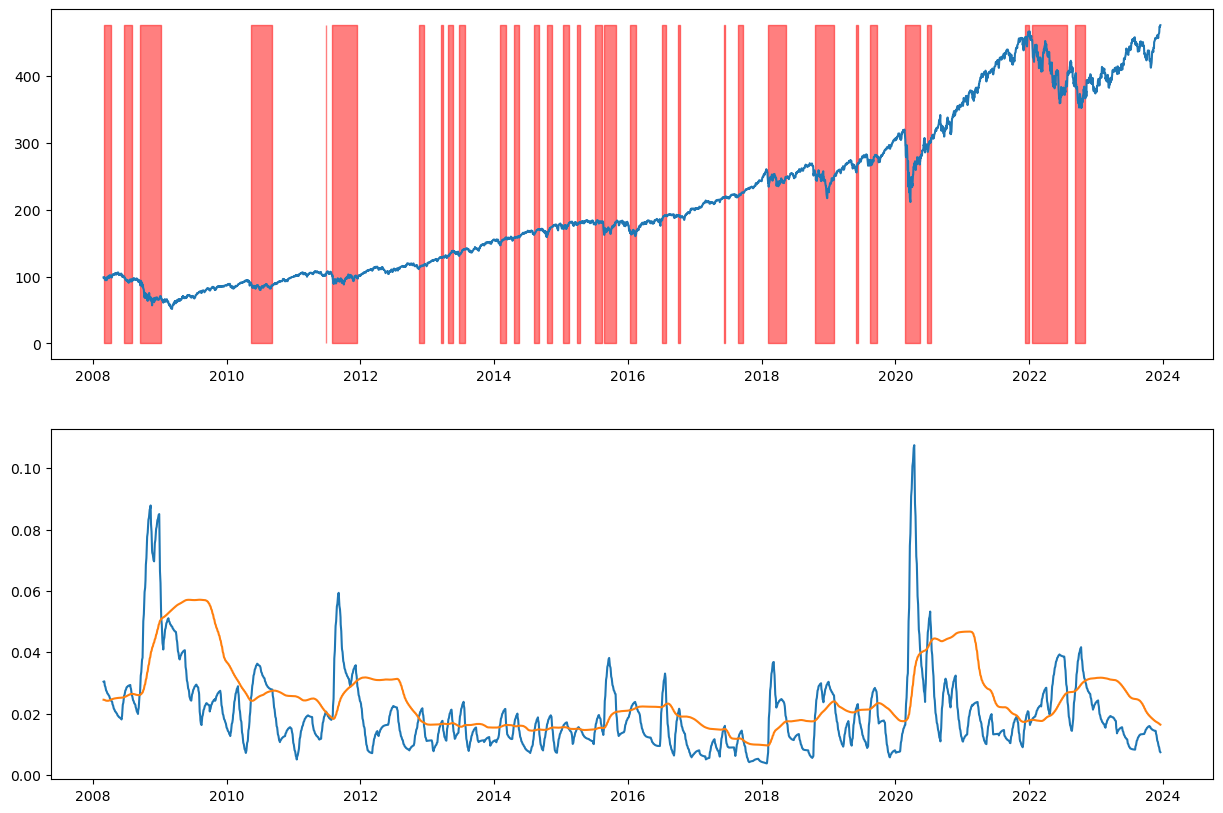

In [177]:
fig, ax = plt.subplots(nrows = 2, figsize=(15,10))
ax[0].plot(df_risk['IVV']);
ax[0].fill_between(df_risk.index, 0, df_risk['IVV'].max(), where=df_risk['breached']==1, color='red', alpha=0.5)
ax[1].plot(df_risk['Risk']);
ax[1].plot(df_risk['limit']);

In [178]:
df_risk[df_risk['action'] != 0]

,Risk,limit,breached,action,IVV
2008-04-09,0.024407,0.024521,0,-1.0,100.559151
2008-06-20,0.025783,0.025368,1,1.0,98.224052
2008-08-01,0.026040,0.026439,0,-1.0,94.091606
2008-09-15,0.026432,0.026094,1,1.0,89.771385
2009-01-12,0.049033,0.050969,0,-1.0,65.832466
...,...,...,...,...,...
2022-01-03,0.017449,0.017830,0,-1.0,466.708679
2022-01-17,0.018068,0.017963,1,1.0,453.976959
2022-07-27,0.026376,0.026791,0,-1.0,394.587189
2022-09-09,0.027700,0.027430,1,1.0,400.137634


In [179]:
dfw_risk = pd.DataFrame()
for i, (index, row) in enumerate(full_df[dfw_mom.first_valid_index():].iterrows()):
    if index > dfw_mom.index[-1]:
        continue
    else:
        given_weights = dfw_mom.loc[index:].iloc[0]
        if index in df_risk.index:
            if (df_risk.loc[index]['breached'] == 1) and (df_risk.loc[index]['action'] == 1):
                print('breached', index)
                given_weights = pd.DataFrame(index=[index], columns = dfw_mom.columns).fillna(0).T
                dfw_risk = pd.concat([dfw_risk, pd.DataFrame(given_weights).T], axis=0)  
            
            elif (df_risk.loc[index]['breached'] == 0) and (df_risk.loc[index]['action'] == -1):
                print('reinvest', index)
                given_weights = pd.DataFrame(index= dfw_mom.columns, data=given_weights.values, columns = [index])
                dfw_risk = pd.concat([dfw_risk, pd.DataFrame(given_weights).T], axis=0)  
            else:
                if index in dfw_mom.index and (df_risk.loc[index]['breached'] == 0): #standard monthly rebalancing
                    dfw_risk = pd.concat([dfw_risk, pd.DataFrame(given_weights).T], axis=0) 
dfw_risk= dfw_risk[~dfw_risk.index.duplicated(keep='last')]

reinvest 2008-04-09 00:00:00
breached 2008-06-20 00:00:00
reinvest 2008-08-01 00:00:00
breached 2008-09-15 00:00:00
reinvest 2009-01-12 00:00:00
breached 2010-05-14 00:00:00
reinvest 2010-09-09 00:00:00
breached 2011-06-28 00:00:00
reinvest 2011-07-01 00:00:00
breached 2011-08-01 00:00:00
reinvest 2011-12-14 00:00:00
breached 2012-11-15 00:00:00
reinvest 2012-12-13 00:00:00
breached 2013-03-15 00:00:00
reinvest 2013-03-27 00:00:00
breached 2013-04-24 00:00:00
reinvest 2013-05-21 00:00:00
breached 2013-06-24 00:00:00
reinvest 2013-07-29 00:00:00
breached 2014-01-31 00:00:00
reinvest 2014-03-10 00:00:00
breached 2014-04-18 00:00:00
reinvest 2014-05-15 00:00:00
breached 2014-08-08 00:00:00
reinvest 2014-09-04 00:00:00
breached 2014-10-14 00:00:00
reinvest 2014-11-14 00:00:00
breached 2015-01-12 00:00:00
reinvest 2015-02-12 00:00:00
breached 2015-03-31 00:00:00
reinvest 2015-04-15 00:00:00
breached 2015-07-07 00:00:00
reinvest 2015-08-12 00:00:00
breached 2015-08-24 00:00:00
reinvest 2015-

In [180]:
full_df['CASH'] = 100 #easy workaround to account for a cash position in the portfolio. We assume no interest earned
dfw_risk['CASH'] = 1 - dfw_risk.sum(axis=1)

<Axes: >

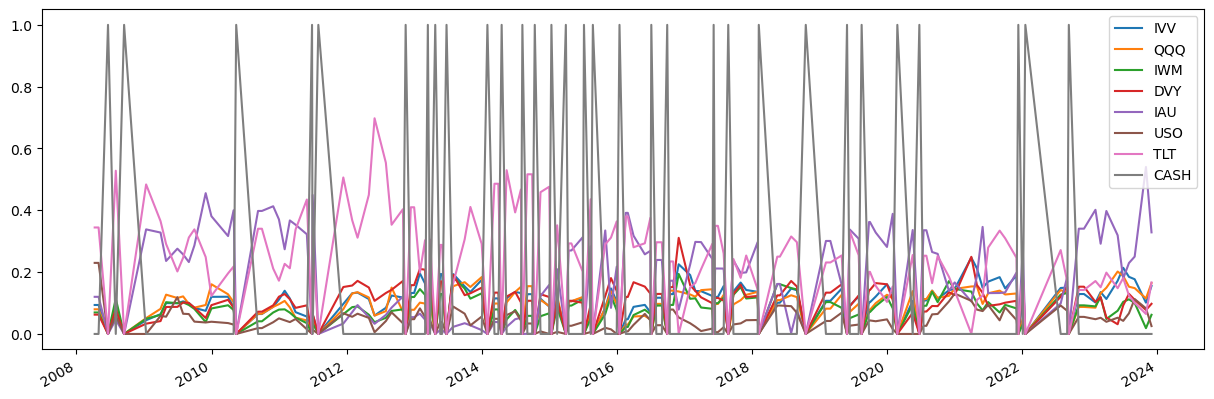

In [181]:
dfw_risk.plot()

In [182]:
results_risk = run_backtest(dfw_risk, 10000)

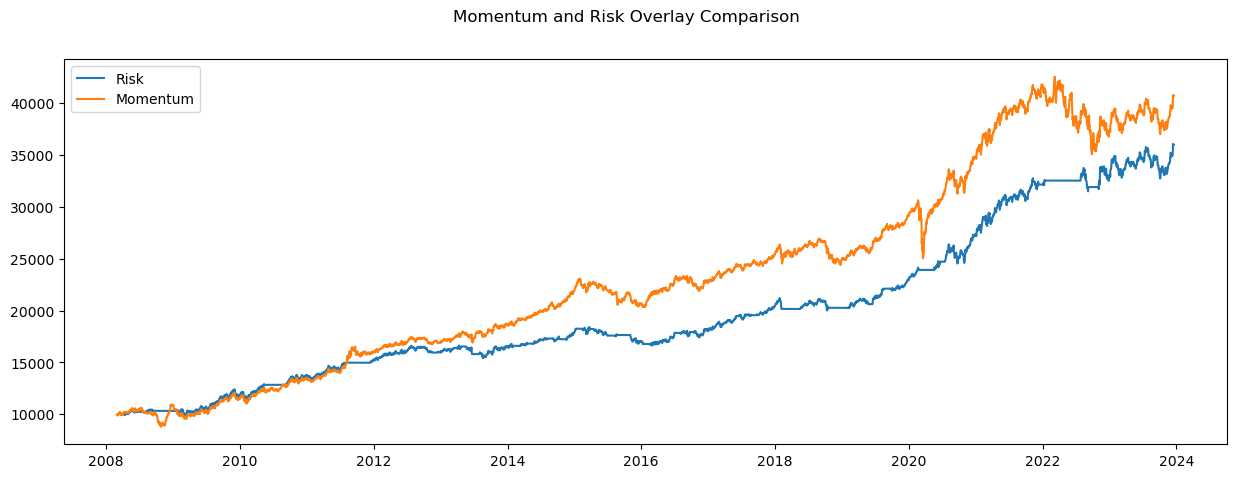

In [183]:
fig, ax = plt.subplots()
fig.suptitle('Momentum and Risk Overlay Comparison')
plt.plot(results_risk['Cumulative'], label='Risk')
plt.plot(results_mom['Cumulative'], label='Momentum')
plt.legend();

In [184]:
#Comparison of volatility
print(cum_res_date(results_mom['Cumulative'].copy(), start_date).pct_change().std()*np.sqrt(252))
print(cum_res_date(results_risk['Cumulative'].copy(), start_date).pct_change().std()*np.sqrt(252))


0.09970199787951393
0.07439409554325573


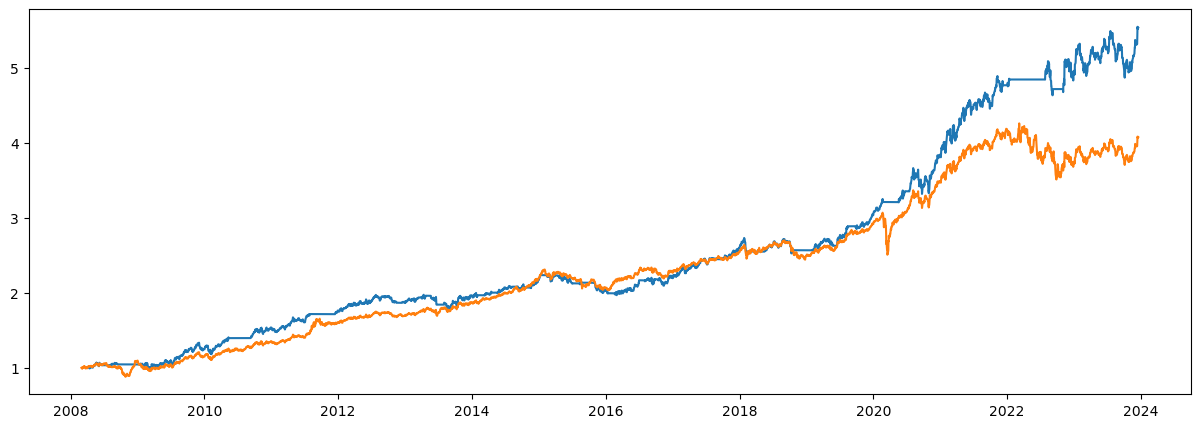

In [185]:
#ex-post vol adjusted comparison
vol_adj = cum_res_date(results_risk['Cumulative'].copy(), start_date).pct_change() * (0.10/0.074)
vol_adj_cum = (1+vol_adj).cumprod()
plt.plot(vol_adj_cum)
plt.plot(cum_res_date(results_mom['Cumulative'].copy(), start_date))

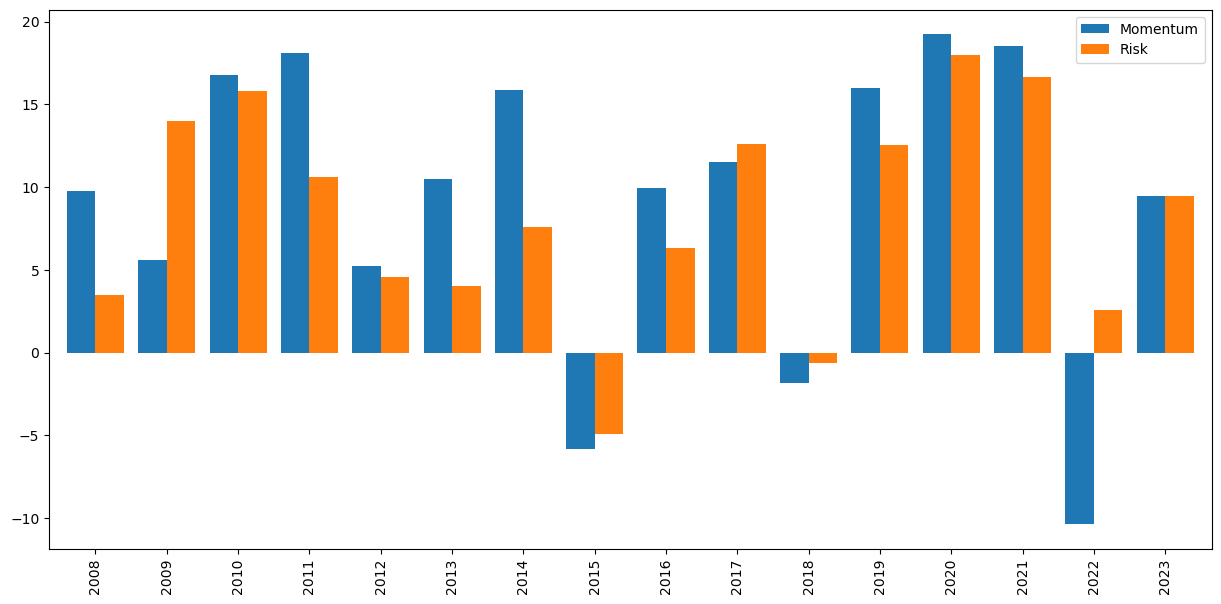

In [186]:
yearly_returns_risk = ((results_risk['Returns']).groupby([results_risk['Returns'].index.year]).sum()*100)
comb_returns = pd.concat([yearly_returns_mom, yearly_returns_risk], axis=1)
comb_returns.columns = ['Momentum', 'Risk']
comb_returns.plot(kind='bar', width=0.8, figsize=(15,7));

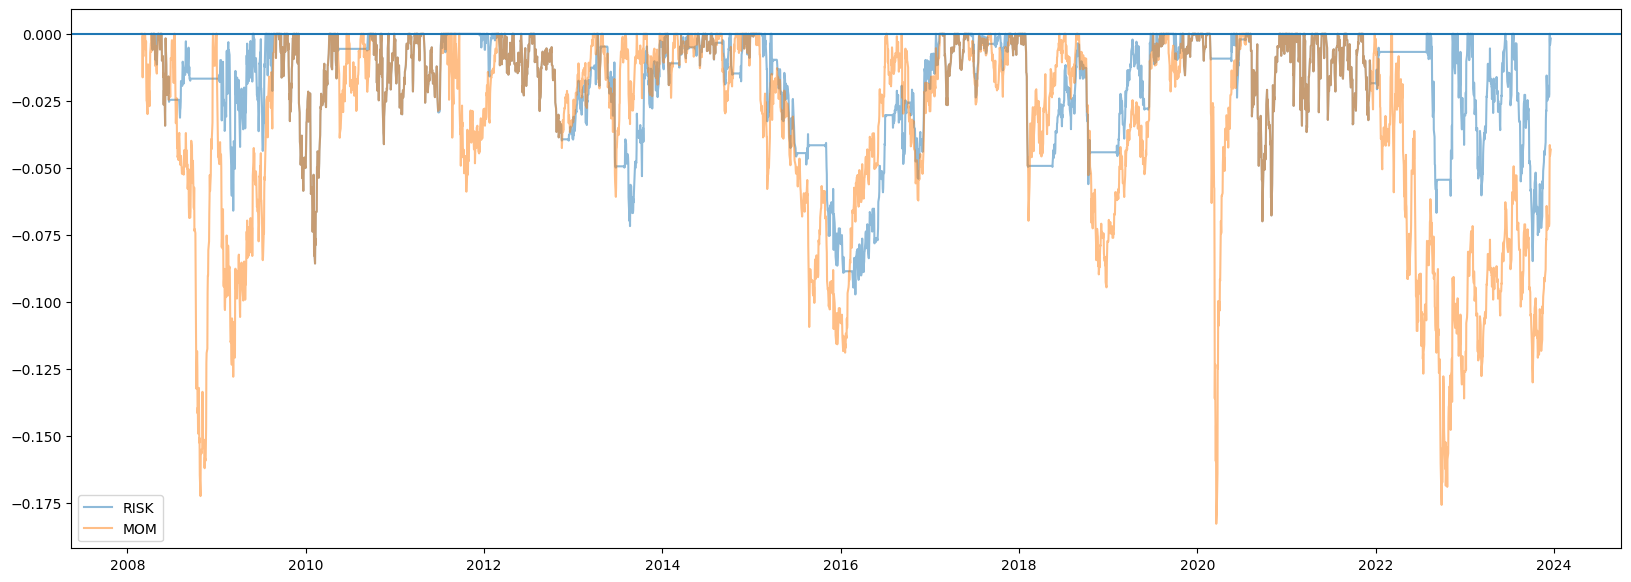

In [187]:
## This graph shows the merit of the idea: we do not give up too much upside but significantly reduce the large drawdowns
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(cum_res_date(results_risk['Cumulative'].copy(), start_date)/cum_res_date(results_risk['Cumulative'].copy(), start_date).expanding().max()-1, label='RISK', alpha=0.5)
ax.plot(cum_res_date(results_mom['Cumulative'].copy(), start_date)/cum_res_date(results_mom['Cumulative'].copy(), start_date).expanding().max()-1, label='MOM', alpha=0.5)
ax.axhline(0)
plt.legend();

## VIX Managed Portfolio Strategies
One idea for future testing is to scale the portfolio using a VIX realized volatility.

A potential idea is presented in the [VIX-managed portfolios paper](https://papers.ssrn.com/sol3/Papers.cfm?abstract_id=4507634)

Using the Implied volatility (”VIX-managed strategy”) formula: <br>
$ \sigma_b = \frac{1}{12}\  \sum_{d\in t} VIX^2_{d} $ <br>Where $ VIX_d $ is the observed value of the CBOE implied volatility index on day d in month t <br>




In [188]:
#squared sum of daily levels of VIX over the past month is high and vice-versa
vix = yf.download('^VIX', start='2010-01-01')

[*********************100%%**********************]  1 of 1 completed


In [189]:
vix_squared = ((vix['Close']**2).resample('M').sum())/12
vix_squared_monthly = vix_squared.copy()
vix_squared = vix_squared.resample('B').last().fillna(method='ffill')

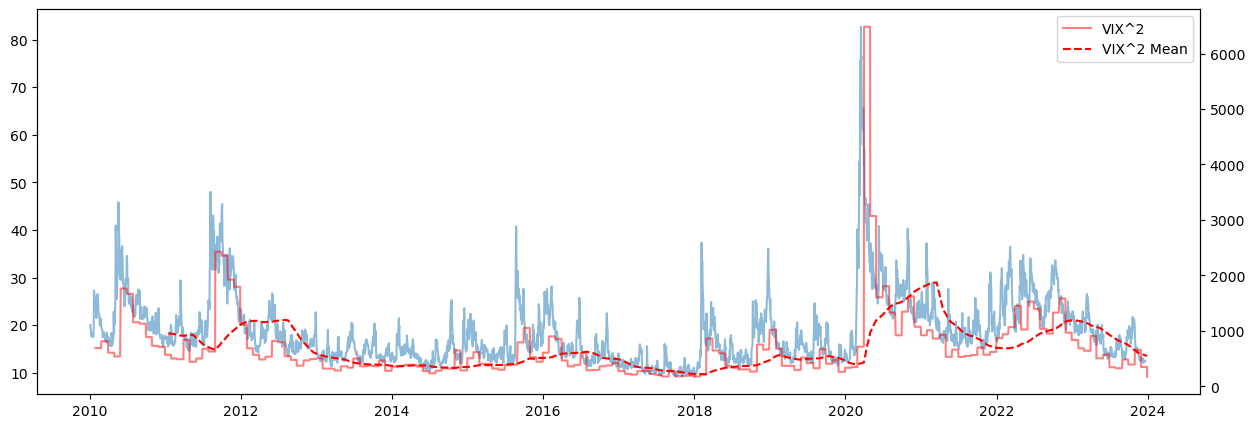

In [190]:
fig, ax = plt.subplots()
ax.plot(vix['Close'], label='VIX', alpha=0.5)
ax1=ax.twinx()
ax1.plot(vix_squared, label='VIX^2', color='red', alpha=0.5)
ax1.plot(vix_squared.rolling(window=252).mean(), color='red', linestyle='--', label='VIX^2 Mean')
plt.legend();

In [191]:
vix_strategy = results_mom['Cumulative'].copy()
vix_strategy.columns = ['Strategy']
diff_vix_strategy = abs(vix_squared_monthly.diff()).shift(1)
vix_strategy = pd.concat([vix_strategy, diff_vix_strategy.resample('B').last().fillna(method='bfill').rename('VIX')], axis=1)

Without proper testing, the scaling is probably too slow using only monthly rebalancing

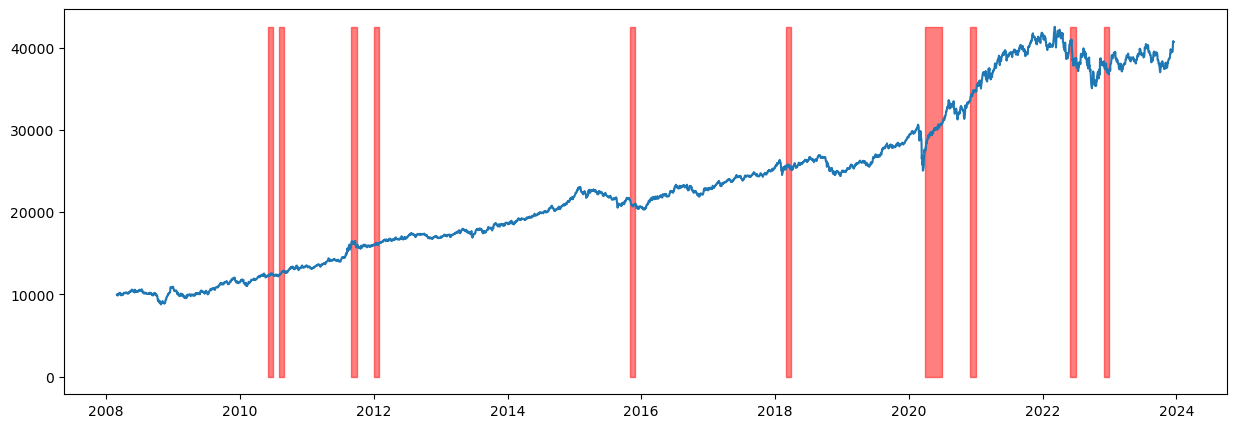

In [192]:
fig, ax = plt.subplots()
ax.plot(results_mom['Cumulative'])
ax.fill_between(vix_strategy.index, 0, vix_strategy['Cumulative'].max(), where=vix_strategy['VIX']>500, color='red', alpha=0.5)